# Titanic: Machine Learning from Disaster

In [1]:
# https://www.kaggle.com/c/titanic

In [2]:
import sklearn
import pandas as pd

In [244]:
!pip install ipython --isolated

In [8]:
# Загружаем данные из файлов
train = pd.read_csv('./homework/train.csv')
test = pd.read_csv('./homework/test.csv')

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Предобработка данных

In [10]:
# Заполняем пропуски в данных медианными 
# значениями факторов на обучающей выборке
train_median = train.median()
train_imp = train.fillna(train_median)
test_imp = test.fillna(train_median)

In [11]:
# Бинаризуем категориальные признаки
CATEGORY_COL = ['Sex', 'Pclass', 'Embarked']
train_dummies = pd.get_dummies(train_imp, columns=CATEGORY_COL, drop_first=True)
test_dummies = pd.get_dummies(test_imp, columns=CATEGORY_COL, drop_first=True)

In [12]:
train_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,1,0,1


In [13]:
# Удаляем лишние столбцы
DROP_COL = ['PassengerId', 'Name', 'Ticket', 'Cabin']
TARGET_COL = 'Survived'
X_train = train_dummies.drop(DROP_COL + [TARGET_COL], axis=1)
y_train = train_dummies[TARGET_COL]
X_test = test_dummies.drop(DROP_COL, axis=1)

## Предсказание моделей для стеккинга

In [241]:
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
import catboost import


def cross_val_predict_proba(estimator, X_train, y_train):
    kfold = KFold(n_splits=5, shuffle=True, random_state=None)
    return cross_val_predict(estimator, X_train, y_train, cv=kfold, method='predict_proba')

# TODO: подобрать гиперпараметры для ансамблей

In [137]:
import warnings
warnings.filterwarnings('ignore')


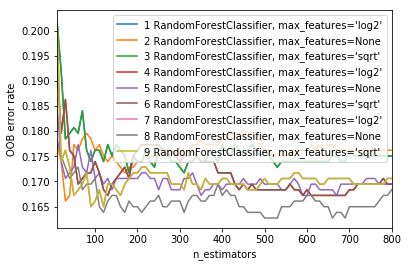

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict


# Устанавливаем аргумент warm_start=True для дообучения модели
# подберем max_features и max_depth по obb
ensemble_clfs = [
    ("1 RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',max_depth= 4,
                               oob_score=True,
                               random_state=42)),
    ("2 RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,max_depth= 4,
                               oob_score=True,
                               random_state=42)),
    ("3 RandomForestClassifier, max_features='sqrt'",
    RandomForestClassifier(warm_start=True, oob_score=True,max_depth= 4,
                           max_features="sqrt",
                           random_state=42)),
    ("4 RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',max_depth= 6,
                               oob_score=True,
                               random_state=42)),
    ("5 RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,max_depth= 6,
                               oob_score=True,
                               random_state=42)),
    ("6 RandomForestClassifier, max_features='sqrt'",
    RandomForestClassifier(warm_start=True, oob_score=True,max_depth= 6,
                           max_features="sqrt",
                           random_state=42)),
    ("7 RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',max_depth= 8,
                               oob_score=True,
                               random_state=42)),
    ("8 RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,max_depth= 8,
                               oob_score=True,
                               random_state=42)),
    ("9 RandomForestClassifier, max_features='sqrt'",
    RandomForestClassifier(warm_start=True, oob_score=True,max_depth= 8,
                           max_features="sqrt",
                           random_state=42)),
]


error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Диапазон значений числа базовых деревьев
min_estimators = 10
max_estimators = 800

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1,10):
        # Задаем число 
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)
        # Сохраняем значение ошибки
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Выводим зависимость качества от числа базовых моделей
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

148 0.807387862797


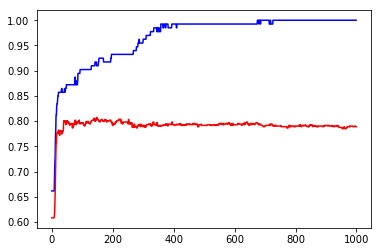

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Разбиваем выборку на обучение и тест
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, 
                                                        y_train,
                                                        test_size=0.85, 
                                                        random_state=42)
#Параметры для ручного тунинга
LEARNING_RATE = 0.05
MAX_DEPTH = 7
SUBSAMPLE = 0.85
MAX_FEATURES = 1
LEAF = 8

# Создаем класс модели градиентного бустинга
clf = GradientBoostingClassifier(n_estimators=1000, 
                                 learning_rate=LEARNING_RATE,
                                 max_depth=MAX_DEPTH, 
                                 subsample=SUBSAMPLE,
                                 max_features=MAX_FEATURES,
                                 min_samples_leaf=LEAF, random_state = 42)

# Обучаем модель на обучающей выборке
clf.fit(X_train_, y_train_)

test_score = np.zeros((clf.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_predict(X_test_)):
    test_score[i] = accuracy_score(y_test_, y_pred)
    
train_score = np.zeros((clf.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_predict(X_train_)):
    train_score[i] = accuracy_score(y_train_, y_pred)

# Находим оптимальное число итераций на тесте
print(np.argmax(test_score), np.max(test_score))



# Выводим зависимость качества от числа итераций
plt.plot(range(len(train_score)), train_score, 'b-',
         range(len(test_score)), test_score, 'r-')

In [210]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, 
                                                        y_train,
                                                        test_size=0.85, 
                                                        random_state=42)

In [327]:
cat_clf = CatBoostClassifier(iterations=500, random_seed=42, loss_function="Logloss",learning_rate=0.01,depth=2,l2_leaf_reg =0.01)

In [328]:
#Подберем параметры CatBoost-у  ручками меняем learning_rate depth l2_leaf_reg  - смотрим за iterations и на bestTest = 0.4531328147
# bestIteration = 265

In [329]:
cat_clf.fit(X_train_.values, y_train_.values, use_best_model=True, eval_set=(X_test_.values,y_test_.values),verbose=True)

Borders generated
0:	learn 0.6874883667	test 0.6884048564	bestTest 0.6884048564	passed: 0.00804 sec	total: 9.66ms	remaining: 4.82s
1:	learn 0.6811958166	test 0.6830251666	bestTest 0.6830251666	passed: 0.00937 sec	total: 19.3ms	remaining: 4.81s
2:	learn 0.6749416659	test 0.6778289101	bestTest 0.6778289101	passed: 0.00877 sec	total: 28.4ms	remaining: 4.7s
3:	learn 0.6702084754	test 0.6738132318	bestTest 0.6738132318	passed: 0.012 sec	total: 40.9ms	remaining: 5.07s
4:	learn 0.6631134434	test 0.6675950373	bestTest 0.6675950373	passed: 0.00831 sec	total: 49.4ms	remaining: 4.89s
5:	learn 0.6561974127	test 0.6615475859	bestTest 0.6615475859	passed: 0.00976 sec	total: 59.5ms	remaining: 4.9s
6:	learn 0.6509288059	test 0.6570203557	bestTest 0.6570203557	passed: 0.00816 sec	total: 68.2ms	remaining: 4.8s
7:	learn 0.6443105166	test 0.6512559525	bestTest 0.6512559525	passed: 0.00484 sec	total: 73.3ms	remaining: 4.51s
8:	learn 0.6378603166	test 0.6456515988	bestTest 0.6456515988	passed: 0.00408 sec	t

77:	learn 0.4491196332	test 0.5021394633	bestTest 0.5021394633	passed: 0.0107 sec	total: 615ms	remaining: 3.33s
78:	learn 0.4479146632	test 0.5012695242	bestTest 0.5012695242	passed: 0.00801 sec	total: 623ms	remaining: 3.32s
79:	learn 0.4469734478	test 0.5004198974	bestTest 0.5004198974	passed: 0.00669 sec	total: 631ms	remaining: 3.31s
80:	learn 0.4460898935	test 0.4998795907	bestTest 0.4998795907	passed: 0.00514 sec	total: 636ms	remaining: 3.29s
81:	learn 0.445306541	test 0.4994574369	bestTest 0.4994574369	passed: 0.00802 sec	total: 645ms	remaining: 3.29s
82:	learn 0.4440542306	test 0.4986749829	bestTest 0.4986749829	passed: 0.00842 sec	total: 653ms	remaining: 3.28s
83:	learn 0.4433067929	test 0.4980786658	bestTest 0.4980786658	passed: 0.00254 sec	total: 656ms	remaining: 3.25s
84:	learn 0.4424114445	test 0.4976456394	bestTest 0.4976456394	passed: 0.00449 sec	total: 661ms	remaining: 3.23s
85:	learn 0.4415389219	test 0.4971185684	bestTest 0.4971185684	passed: 0.00832 sec	total: 670ms	re

153:	learn 0.3884395062	test 0.4671706802	bestTest 0.4671706802	passed: 0.00729 sec	total: 1.02s	remaining: 2.3s
154:	learn 0.3881277386	test 0.4670204403	bestTest 0.4670204403	passed: 0.0104 sec	total: 1.03s	remaining: 2.3s
155:	learn 0.3879253147	test 0.4669854539	bestTest 0.4669854539	passed: 0.00235 sec	total: 1.04s	remaining: 2.29s
156:	learn 0.3872064522	test 0.4672000021	bestTest 0.4669854539	passed: 0.00539 sec	total: 1.04s	remaining: 2.28s
157:	learn 0.386886935	test 0.467205438	bestTest 0.4669854539	passed: 0.00372 sec	total: 1.05s	remaining: 2.27s
158:	learn 0.3857678472	test 0.4663276028	bestTest 0.4663276028	passed: 0.0043 sec	total: 1.05s	remaining: 2.25s
159:	learn 0.3850642994	test 0.4660637365	bestTest 0.4660637365	passed: 0.00847 sec	total: 1.06s	remaining: 2.25s
160:	learn 0.3847348925	test 0.465893899	bestTest 0.465893899	passed: 0.00972 sec	total: 1.07s	remaining: 2.25s
161:	learn 0.384583232	test 0.4657462178	bestTest 0.4657462178	passed: 0.00906 sec	total: 1.08s	

236:	learn 0.353853842	test 0.4556329784	bestTest 0.4555175582	passed: 0.0105 sec	total: 1.63s	remaining: 1.81s
237:	learn 0.3535568014	test 0.4554738095	bestTest 0.4554738095	passed: 0.00904 sec	total: 1.64s	remaining: 1.81s
238:	learn 0.3532325569	test 0.4554120315	bestTest 0.4554120315	passed: 0.00755 sec	total: 1.65s	remaining: 1.8s
239:	learn 0.3530047616	test 0.4553565038	bestTest 0.4553565038	passed: 0.00853 sec	total: 1.66s	remaining: 1.8s
240:	learn 0.3526874147	test 0.4552996992	bestTest 0.4552996992	passed: 0.00872 sec	total: 1.67s	remaining: 1.79s
241:	learn 0.3514720902	test 0.4550388356	bestTest 0.4550388356	passed: 0.00771 sec	total: 1.68s	remaining: 1.79s
242:	learn 0.3512788294	test 0.455019947	bestTest 0.455019947	passed: 0.00335 sec	total: 1.68s	remaining: 1.78s
243:	learn 0.3509648139	test 0.4546640059	bestTest 0.4546640059	passed: 0.00475 sec	total: 1.69s	remaining: 1.77s
244:	learn 0.350693626	test 0.4547093782	bestTest 0.4546640059	passed: 0.00208 sec	total: 1.69

326:	learn 0.3295042964	test 0.4552337532	bestTest 0.4531328147	passed: 0.00598 sec	total: 2.25s	remaining: 1.19s
327:	learn 0.3294327186	test 0.4552115396	bestTest 0.4531328147	passed: 0.00806 sec	total: 2.26s	remaining: 1.18s
328:	learn 0.3285865166	test 0.4550610353	bestTest 0.4531328147	passed: 0.00964 sec	total: 2.27s	remaining: 1.18s
329:	learn 0.3283633098	test 0.4551267493	bestTest 0.4531328147	passed: 0.00945 sec	total: 2.28s	remaining: 1.17s
330:	learn 0.3282782557	test 0.4551107561	bestTest 0.4531328147	passed: 0.00891 sec	total: 2.29s	remaining: 1.17s
331:	learn 0.3279056905	test 0.4551955583	bestTest 0.4531328147	passed: 0.0086 sec	total: 2.29s	remaining: 1.16s
332:	learn 0.3274471245	test 0.4551105058	bestTest 0.4531328147	passed: 0.00957 sec	total: 2.31s	remaining: 1.16s
333:	learn 0.3273655102	test 0.4550653635	bestTest 0.4531328147	passed: 0.00728 sec	total: 2.31s	remaining: 1.15s
334:	learn 0.3272245754	test 0.455088881	bestTest 0.4531328147	passed: 0.00806 sec	total:

401:	learn 0.312532627	test 0.4562739182	bestTest 0.4531328147	passed: 0.00991 sec	total: 2.87s	remaining: 699ms
402:	learn 0.3121345387	test 0.4566092322	bestTest 0.4531328147	passed: 0.0103 sec	total: 2.88s	remaining: 693ms
403:	learn 0.3119808503	test 0.4565995917	bestTest 0.4531328147	passed: 0.00313 sec	total: 2.88s	remaining: 685ms
404:	learn 0.311872643	test 0.4566867748	bestTest 0.4531328147	passed: 0.00366 sec	total: 2.88s	remaining: 677ms
405:	learn 0.3116004464	test 0.4570037089	bestTest 0.4531328147	passed: 0.0111 sec	total: 2.9s	remaining: 671ms
406:	learn 0.311315252	test 0.4570194087	bestTest 0.4531328147	passed: 0.0103 sec	total: 2.91s	remaining: 664ms
407:	learn 0.3112094179	test 0.4570877706	bestTest 0.4531328147	passed: 0.00602 sec	total: 2.91s	remaining: 657ms
408:	learn 0.3111058766	test 0.4571570532	bestTest 0.4531328147	passed: 0.00868 sec	total: 2.92s	remaining: 650ms
409:	learn 0.3110591156	test 0.45715748	bestTest 0.4531328147	passed: 0.00828 sec	total: 2.93s	

494:	learn 0.2971756161	test 0.4620851584	bestTest 0.4531328147	passed: 0.00816 sec	total: 3.48s	remaining: 35.2ms
495:	learn 0.2970426546	test 0.4620103055	bestTest 0.4531328147	passed: 0.00835 sec	total: 3.49s	remaining: 28.2ms
496:	learn 0.2969138163	test 0.4621371332	bestTest 0.4531328147	passed: 0.00886 sec	total: 3.5s	remaining: 21.1ms
497:	learn 0.2968808502	test 0.4622234179	bestTest 0.4531328147	passed: 0.00763 sec	total: 3.51s	remaining: 14.1ms
498:	learn 0.29647666	test 0.4622481627	bestTest 0.4531328147	passed: 0.00926 sec	total: 3.52s	remaining: 7.05ms
499:	learn 0.2964473746	test 0.4622850267	bestTest 0.4531328147	passed: 0.0102 sec	total: 3.53s	remaining: 0us

bestTest = 0.4531328147
bestIteration = 265

Shrink model to first 266 iterations.


In [330]:

# инициализирем модели с подобранными гиперпараметрами
rf_estimator = RandomForestClassifier(n_estimators=500, max_depth= 8, random_state= 42,oob_score=True)
gb_estimator = GradientBoostingClassifier(n_estimators=148,min_samples_leaf=8, max_depth= 7, learning_rate = 0.05, max_features = 1, subsample = 0.85, random_state= 42)
cat_estimator = CatBoostClassifier(iterations=266,random_seed=42, loss_function="Logloss",learning_rate=0.01,depth=2,l2_leaf_reg =0.01)

# получаем предсказания вероятностей ансамблей на кросс-валидации для обучающей выборки
rf_train_pred = cross_val_predict_proba(rf_estimator, X_train, y_train)
gb_train_pred = cross_val_predict_proba(gb_estimator, X_train, y_train)
cat_train_pred = cross_val_predict_proba(cat_estimator, X_train.values, y_train.values)

X_train_stack = np.stack([rf_train_pred[:,1], gb_train_pred[:,1],cat_train_pred[:,1]], axis=1)

#X_train_stack = np.stack([rf_train_pred[:,1],cat_train_pred[:,1]], axis=1)

# получаем предсказания ансамблей для тестовой выборки
rf_test_pred = rf_estimator.fit(X_train, y_train).predict_proba(X_test)
gb_test_pred = gb_estimator.fit(X_train, y_train).predict_proba(X_test)
cat_test_pred = cat_estimator.fit(X_train.values, y_train.values).predict_proba(X_test.values)

In [331]:
#X_test_stack = np.stack([rf_test_pred[:,1],cat_test_pred[:,1]], axis=1)
X_test_stack = np.stack([rf_test_pred[:,1], gb_test_pred[:,1],cat_test_pred[:,1]], axis=1)

## Объединяем предсказания ансамблей с помощью логистической регрессии

In [332]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [363]:
# # TODO: подобрать гиперпараметры LogisticRegression

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = LogisticRegression(penalty='l2', random_state = 42, max_iter=1000)
gs = GridSearchCV(clf, param_grid,  scoring='log_loss', cv=5)
gs.fit(X_train_stack, y_train)
print ('gs.best_score_:', gs.best_score_)

gs.best_score_: -0.414366322237


In [364]:
gs.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [365]:
logreg = gs.best_estimator_.fit(X_train_stack, y_train)
predicted = logreg.predict(X_test_stack)

In [366]:
logreg.coef_

array([[ 3.61657394,  0.81329569,  1.637532  ]])

## Формируем фалй для отправки

In [339]:
with open('submission.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], predicted):
        out.write('%s,%s\n' % (passenger, y))

Your Best Entry 
Your submission scored 0.78947, which is not an improvement of your best score. Keep trying!

In [341]:
#стеккинг RF и CatBoost дал 0.80383 без подбора параметров лог регресии)))